In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [46]:
df = pd.read_csv('coffee_orders.csv',  encoding = "latin1")
df.head()

,Order ID,Customer ID,Location ID,Time of purchase,PreTax Total,Customer Order,Quantity
0,1897,3957,101,2024-11-06 00:50:29,16.70,Mocha Frappe Latte:5:3.34,5
1,7304,7905,104,2024-11-06 21:16:17,27.10,Matcha Latte:5:5.42,5
2,9623,3957,104,2024-11-03 09:34:35,4.66,Chai Latte:1:4.66,1
3,8113,7905,100,2024-11-04 07:31:56,4.12,Frappe Latte:1:4.12,1
4,6606,5124,101,2024-11-01 17:11:46,3.34,Mocha Frappe Latte:1:3.34,1


In [47]:
# Assuming 'Order Date' is the column with datetime information
df['Time of purchase'] = pd.to_datetime(df['Time of purchase'])  # Ensure it's in datetime format

# Create 'Hour' column (extract hour from the datetime)
df['Hour'] = df['Time of purchase'].dt.hour

# Create 'Day_of_week' column (extract day of the week as a number, Monday=0, Sunday=6)
df['Day_of_week'] = df['Time of purchase'].dt.dayofweek

# Now group by Customer ID and aggregate
aggregated_df = df.groupby('Customer ID').agg({
    'Order ID': 'count',  # Number of orders for the customer
    'PreTax Total': 'sum',  # Sum up the total spent
    'Quantity': 'sum',  # Total quantity of items
    'Hour': 'mean',  # Average time of purchase (hour of the day)
    'Day_of_week': lambda x: list(set(x)),  # Unique days the customer visited
    'Customer Order': lambda x: '; '.join(x)  # Combine all orders into a single string
}).reset_index()

# Rename columns for clarity
aggregated_df = aggregated_df.rename(columns={
    'Order ID': 'Total_Orders',
    'PreTax Total': 'Total_Spent',
    'Quantity': 'Total_Quantity',
    'Day_of_week': 'Unique_Visit_Days',
    'Customer Order': 'All_Orders'
})

# Display the resulting dataset
aggregated_df.head()


,Customer ID,Total_Orders,Total_Spent,Total_Quantity,Hour,Unique_Visit_Days,All_Orders
0,1005,4,30.16,7,14.75,"[0, 1, 6]",Mocha Frappe Latte:1:3.34; Hard Boiled Eggs:1:...
1,1016,1,7.88,2,14.00,[0],Tiramisu Latte:2:3.94
2,1043,2,7.81,2,5.50,"[2, 4]",Butter Crumb Cake:1:4.63; Caramel Frappe Latte...
3,1046,1,4.63,1,22.00,[0],Butter Crumb Cake:1:4.63
4,1059,1,2.84,1,2.00,[1],Cinnamon Bun:1:2.84


In [48]:
# Label dataset
# Find out how many items are ordered by a customer per visit
aggregated_df['Avg_Items_Per_Order'] = aggregated_df['Total_Quantity'] / aggregated_df['Total_Orders']

def label_customer(row):
    # Label based on visit frequency
    # a customer is a regular if they come in at least 3 times a week
    if len(row['Unique_Visit_Days']) >= 3:
        visit_label = 'Regular Customer'
    else:
        visit_label = 'Non-Regular Customer'
    
    # Label based on items per order
    # a customer is a high spender if they average at least 2 items per order
    if row['Avg_Items_Per_Order'] >= 2:
        spend_label = 'High Spend Customer'
    else:
        spend_label = 'Low Spend Customer'
    
    return f'{visit_label} - {spend_label}'

In [49]:
aggregated_df['Customer_Label'] = aggregated_df.apply(label_customer, axis=1)

# Display the resulting labels
aggregated_df[['Customer ID', 'Customer_Label']].head()
aggregated_df

,Customer ID,Total_Orders,Total_Spent,Total_Quantity,Hour,Unique_Visit_Days,All_Orders,Avg_Items_Per_Order,Customer_Label
0,1005,4,30.16,7,14.75,"[0, 1, 6]",Mocha Frappe Latte:1:3.34; Hard Boiled Eggs:1:...,1.75,Regular Customer - Low Spend Customer
1,1016,1,7.88,2,14.00,[0],Tiramisu Latte:2:3.94,2.00,Non-Regular Customer - High Spend Customer
2,1043,2,7.81,2,5.50,"[2, 4]",Butter Crumb Cake:1:4.63; Caramel Frappe Latte...,1.00,Non-Regular Customer - Low Spend Customer
3,1046,1,4.63,1,22.00,[0],Butter Crumb Cake:1:4.63,1.00,Non-Regular Customer - Low Spend Customer
4,1059,1,2.84,1,2.00,[1],Cinnamon Bun:1:2.84,1.00,Non-Regular Customer - Low Spend Customer
...,...,...,...,...,...,...,...,...,...
955,9944,2,25.45,7,5.50,[5],Hot Chocolate:4:2.89;Eggnog Latte:1:4.67;Corta...,3.50,Non-Regular Customer - High Spend Customer
956,9957,1,5.46,2,22.00,[2],Espresso:2:2.73,2.00,Non-Regular Customer - High Spend Customer
957,9974,2,21.04,5,11.50,"[0, 1]",Roasted Tomato Breakfast Roll:1:3.81;Vegan Bre...,2.50,Non-Regular Customer - High Spend Customer
958,9981,1,5.42,1,16.00,[3],Matcha Latte:1:5.42,1.00,Non-Regular Customer - Low Spend Customer


# Features Engineering


In [50]:
features = aggregated_df[['Total_Orders', 'Total_Spent', 'Total_Quantity', 'Avg_Items_Per_Order']]
labels = aggregated_df['Customer_Label']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
x_Train, x_Test, y_Train, y_Test = train_test_split(scaled_features, labels, test_size = 0.2 , random_state=42)


In [51]:
import pandas as pd
import numpy as np

# Example: Split combined labels and create binary features
# Assuming 'Customer_Label' is a column with combined labels
def split_labels(labels):
    return labels.split(' - ') if isinstance(labels, str) else []

# Apply the split function to create a list of labels for each customer
aggregated_df['Label_List'] = aggregated_df['Customer_Label'].apply(split_labels)

# Now we create binary features for each possible label
all_labels = set(label for label_list in aggregated_df['Label_List'] for label in label_list)
label_map = {label: i for i, label in enumerate(all_labels)}

# Create binary columns for each label
for label in all_labels:
    aggregated_df[label] = aggregated_df['Label_List'].apply(lambda x: 1 if label in x else 0)

# Check the resulting datafr
aggregated_df.head()

# Now you can proceed to use these labels in your clustering or KNN model


,Customer ID,Total_Orders,Total_Spent,Total_Quantity,Hour,Unique_Visit_Days,All_Orders,Avg_Items_Per_Order,Customer_Label,Label_List,High Spend Customer,Non-Regular Customer,Low Spend Customer,Regular Customer
0,1005,4,30.16,7,14.75,"[0, 1, 6]",Mocha Frappe Latte:1:3.34; Hard Boiled Eggs:1:...,1.75,Regular Customer - Low Spend Customer,"[Regular Customer, Low Spend Customer]",0,0,1,1
1,1016,1,7.88,2,14.00,[0],Tiramisu Latte:2:3.94,2.00,Non-Regular Customer - High Spend Customer,"[Non-Regular Customer, High Spend Customer]",1,1,0,0
2,1043,2,7.81,2,5.50,"[2, 4]",Butter Crumb Cake:1:4.63; Caramel Frappe Latte...,1.00,Non-Regular Customer - Low Spend Customer,"[Non-Regular Customer, Low Spend Customer]",0,1,1,0
3,1046,1,4.63,1,22.00,[0],Butter Crumb Cake:1:4.63,1.00,Non-Regular Customer - Low Spend Customer,"[Non-Regular Customer, Low Spend Customer]",0,1,1,0
4,1059,1,2.84,1,2.00,[1],Cinnamon Bun:1:2.84,1.00,Non-Regular Customer - Low Spend Customer,"[Non-Regular Customer, Low Spend Customer]",0,1,1,0


In [55]:
# Initialize knn model
import joblib
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_Train, y_Train)

y_pred = knn.predict(x_Test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_Test, y_pred)
print(f"Accuracy of KNN model: {accuracy * 100:.2f}%")
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


Accuracy of KNN model: 96.35%


['scaler.pkl']

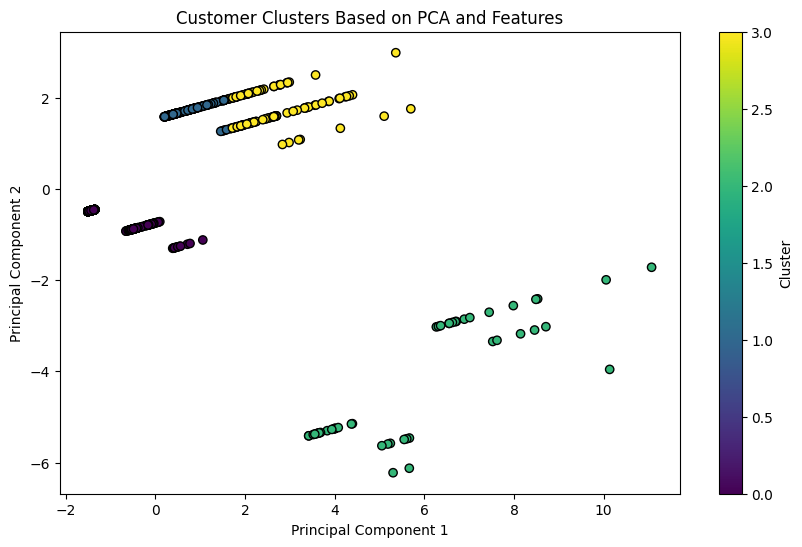

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Extract the features (numeric + one-hot encoded labels)
features = aggregated_df[['Total_Orders', 'Total_Spent', 'Total_Quantity'] + list(all_labels)]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA to reduce features to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Apply KMeans clustering (or use your clustering method)
kmeans = KMeans(n_clusters=4, random_state=42)  # You can change the number of clusters based on your analysis
aggregated_df['Cluster'] = kmeans.fit_predict(scaled_features)

# Extract the first two principal components for plotting
x = reduced_features[:, 0]
y = reduced_features[:, 1]

# Get the cluster labels (used for coloring the points)
clusters = aggregated_df['Cluster'].values

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=clusters, cmap='viridis', marker='o', edgecolors='k')

# Title and labels for the plot
plt.title("Customer Clusters Based on PCA and Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Add a colorbar to show the cluster labels
plt.colorbar(scatter, label='Cluster')

# Display the plot
plt.show()


In [60]:
import plotly.express as px

# Create a new column with the customer label information to display on hover
# Combine the customer ID and the labels into a single string for display on hover
aggregated_df['Hover_Info'] = aggregated_df['Customer ID'].astype(str) + "<br>" + \
                              aggregated_df['Customer_Label'].apply(lambda x: ', '.join(x.split(' - ')))

# Apply KMeans clustering (or use your clustering method)
kmeans = KMeans(n_clusters=4, random_state=42)  # Change number of clusters as necessary
aggregated_df['Cluster'] = kmeans.fit_predict(scaled_features)

# Apply PCA to reduce features to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Add the PCA components to the dataframe for plotting
aggregated_df['PCA_1'] = reduced_features[:, 0]
aggregated_df['PCA_2'] = reduced_features[:, 1]

# Create an interactive scatter plot using Plotly
fig = px.scatter(aggregated_df, 
                 x='PCA_1', 
                 y='PCA_2', 
                 color='Cluster',  # Color by cluster
                 hover_data=['Hover_Info'],  # Hover over customer data (ID and labels)
                 title="Customer Clusters with Hover Info",
                 labels={"PCA_1": "Principal Component 1", "PCA_2": "Principal Component 2"})

# Show the plot
fig.show()


In [65]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler

# Example: Suppose your training data had these one-hot encoded labels
one_hot_columns = ['Regular Customer', 'Non-Regular Customer', 'High Spend Customer', 'Low Spend Customer']

# Fill in new customer data (example: Customer 1001 made 3 orders, spent $150, and bought 5 items)
new_customer_data = pd.DataFrame({
    'Total_Orders': [3],  # Total number of orders
    'Total_Spent': [150],  # Total amount spent
    'Total_Quantity': [5],  # Total quantity of items ordered
    'Regular Customer': [1],  # One-hot encoding for customer type
    'Non-Regular Customer': [0],
    'High Spend Customer': [0],
    'Low Spend Customer': [1]  # Assuming this customer spent a smaller amount per order
})
feature_names = x_Train.columns.tolist()


# Ensure that the columns match the training data columns exactly
for col in one_hot_columns:
    if col not in new_customer_data.columns:
        new_customer_data[col] = 0  # Add missing columns with zero values

# Now, ensure the new data is scaled using the same scaler as used during training
scaler_loaded = joblib.load('scaler.pkl')
new_customer_data_scaled = scaler_loaded.transform(new_customer_data)

# Load the trained KNN model
knn_loaded = joblib.load('knn_model.pkl')

# Predict the label of the new customer
prediction = knn_loaded.predict(new_customer_data_scaled)

# Assuming label_map_inv is available for mapping predictions back to labels
label_map_inv = {
    0: 'Regular Customer',
    1: 'Non-Regular Customer',
    2: 'High Spend Customer',
    3: 'Low Spend Customer'
}

predicted_label = label_map_inv[prediction[0]]

print(f"Predicted Label: {predicted_label}")


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.
